In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import helper
plt.rcParams['savefig.pad_inches'] = 0
vids=["RubberWhale", "Urban2", "Grove3"]

vid=vids[2]
window=(32,32)
tau=0.01
lev=4

path=path1=path2= "../data/all-frames-colour/"+vid
opdir="../results/"+vid
gtpath="../data/ground-truth-flow/"+vid+"/flow10.flo"

In [112]:
def readImages():
	Img1 = cv2.imread(path1)	
	Img2 = cv2.imread(path2)	

	Img1 = np.array(Img1)
	Img2 = np.array(Img2)

	gray1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
	gray2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)

	gray2 = np.array(gray2)
	gray1 = np.array(gray1)

	return Img1, Img2, gray1, gray2


def getHarrisCorners(Img):
	corners = cv2.goodFeaturesToTrack(Img, 200, 0.01, 10, useHarrisDetector=True, k=0.04)

	corners_tuple = []
	for corner in corners:
		c = corner[0]

		corners_tuple.append((int(c[0]), int(c[1])))

	corners_tuple = np.array(corners_tuple)

	return corners, corners_tuple

def videoName():
	return path1.split("/")[3]


In [113]:
def LucasKanadeForwardAdditive(gray1, gray2, windowSize, tau, corners, u0=0, v0=0, refineFlag=False):

	# form window
	hw = int(windowSize[0]/2)

	# shift the window if refineFlag is true
	if refineFlag:
		new_corners = []
		for i in range(len(corners)):
			new_corners.append(
				(int(np.round(corners[i][0]+u0[i])), int(np.round(corners[i][1]+v0[i]))))
		corners = np.array(new_corners)
	
	# normalize the images
	gray1 = gray1/255
	gray2 = gray2/255

	# compute gradients
	gradient_x = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
	gradient_y = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
	gradient_x2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=3)
	gradient_y2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=3)
	gradient_t = gray2-gray1
	gradient_x = (gradient_x+gradient_x2)/2
	gradient_y = (gradient_y+gradient_y2)/2

	# compute optical flow
	all_U = np.zeros((len(corners), 2))
	for i in range(0, len(corners)):
		
		# construct the A and b matrices
		(x, y) = corners[i]
		Ix = gradient_x[y-hw:y+hw+1, x-hw:x+hw+1].reshape(-1, 1)
		Iy = gradient_y[y-hw:y+hw+1, x-hw:x+hw+1].reshape(-1, 1)
		It = gradient_t[y-hw:y+hw+1, x-hw:x+hw+1].reshape(-1, 1)
		A = np.hstack((Ix, Iy))
		b = -It

		# reject per eigenvalue threshold
		lambdas, _ = np.linalg.eig(A.T@A)
		if np.min(lambdas) < tau:
			continue

		# solve for U
		U = np.linalg.lstsq(A, b, rcond=None)[0]
		if refineFlag:
			all_U[i] = U.T + np.array([u0[i], v0[i]])
		else:
			all_U[i] = U.T

	return np.array(all_U)
		

In [114]:
def MultiScaleLucasKanade(gray1, gray2, windowSize, tau, corners, numLevels):
	
	# form the pyramids (reversed because we need low->high res)
	pyr1=[]
	pyr2=[]
	pyr1.append(gray1)
	pyr2.append(gray2)
	for i in range(1, numLevels):	
		pyr1.append(cv2.pyrDown(pyr1[i-1]))
		pyr2.append(cv2.pyrDown(pyr2[i-1]))
	pyr1=np.array(pyr1[::-1], dtype=object)
	pyr2=np.array(pyr2[::-1], dtype=object)

	# estimate optical flow for lowest res image, and keep refininf for subsequent levels
	vels = np.zeros((len(corners), 2))
	for i in range(len(pyr1)):
			tempcorners = corners*(2**(-numLevels+i+1))
			vels = vels*2
			vels = LucasKanadeForwardAdditive(pyr1[i], pyr2[i], windowSize, tau, tempcorners, vels[:, 0], vels[:, 1], refineFlag=True)
				
	return vels

Calculating Optical Flow....
Frame 1 of 7
Frame 2 of 7
Frame 3 of 7
Frame 4 of 7
Frame 5 of 7
Frame 6 of 7
Frame 7 of 7
Calculating EPE and Flow Visualization....
Stitching Outut into Videos....


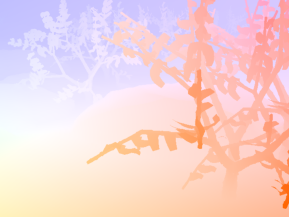

In [115]:
def main():
	global path1, path2, path
	def cv2flow():
		nonlocal corners, corners_tuple, gray1, gray2, Img1, p1
		p1, _, _ = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners, None, winSize=window, maxLevel=lev, criteria=(
			cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, tau))
		p1 = p1.reshape(-1, 2)
		corners = corners.reshape(-1, 2)

	def plot(name):
		nonlocal corners, corners_tuple, gray1, gray2, Img1, p1, i
		plt.quiver(corners[:, 0], corners[:, 1], p1[:, 0] -
                    corners[:, 0], p1[:, 1]-corners[:, 1], color='b', angles='xy')
		plt.quiver(corners_tuple[:, 0], corners_tuple[:, 1],
                    velocities[:, 0], velocities[:, 1], color='r', angles='xy')
		plt.imshow(Img1)
		plt.axis('off')
		plt.autoscale(tight=True)
		plt.savefig(opdir+"/"+name+str(i)+'.png', dpi=400, bbox_inches='tight')
		plt.clf()

	def exportvid(name, img_array):
		out = cv2.VideoWriter(opdir+"/"+name+".avi", cv2.VideoWriter_fourcc(
			*'DIVX'), 2, (img_array[0].shape[1], img_array[0].shape[0]))
	
		for i in range(len(img_array)):
			out.write(img_array[i])
		out.release()
	
	def get_epe(who):
		nonlocal corners, corners_tuple, gray1, gray2, Img1, filetxt, i
		if i!=10:
			return
		gt_flow=helper.read_flow(gtpath)
		gt_flow=gt_flow[corners_tuple[:, 1], corners_tuple[:, 0]]
		if who=="MySingleScale" or who=="MyMultiScale":
			epe=(np.linalg.norm(gt_flow-velocities, axis=1))
		else:
			epe=(np.linalg.norm(gt_flow-(p1-corners), axis=1))
		for j in range(len(epe)):
			if epe[j]>100000000:
				epe[j]=0
		epe=np.mean(epe)
		filetxt=filetxt+who+" EPE: "+str(epe)+"\n"

	def cornervis():
		nonlocal corners, corners_tuple, gray1, gray2, Img1, filetxt, i
		if i!=10:
			return
		plt.imshow(Img1)
		plt.scatter(corners_tuple[:, 0], corners_tuple[:, 1], s=5, c='r')
		plt.axis('off')
		plt.autoscale(tight=True)
		plt.savefig(opdir+"/corners.png", dpi=400, bbox_inches='tight')
		plt.clf()

	
	shutil.rmtree(opdir)
	os.mkdir(opdir)
	filetxt = ""
	imgarr1=[]
	imgarr2=[]

	print("Calculating Optical Flow....")
	
	for i in range(7,14):

		print("Frame "+str(i-6)+" of 7")
		path1 = path1+"/frame"+f"{i:02}"+".png"
		path2 = path2+"/frame"+f"{i+1:02}"+".png"
		

		# read images
		p1 = []
		Img1, _, gray1, gray2 = readImages()
		corners, corners_tuple = getHarrisCorners(gray1)
		cornervis()

		# get flow from opencv
		cv2flow()
		get_epe("cv2")

		# get single scale flow from my implementation
		velocities = LucasKanadeForwardAdditive(
			gray1, gray2, window, tau, corners_tuple)
		plot("single")
		get_epe("MySingleScale")

		# get multi scale flow from my implementation
		velocities = MultiScaleLucasKanade(
			gray1, gray2, window, tau, corners_tuple, lev)
		plot("multi")
		get_epe("MyMultiScale")

		imgarr1.append(cv2.imread(opdir+"/single"+str(i)+'.png'))
		imgarr2.append(cv2.imread(opdir+"/multi"+str(i)+'.png'))


		path1=path
		path2=path
	
	print("Calculating EPE and Flow Visualization....")
	with open(opdir+"/epe.txt", "w") as f:
		f.write(filetxt)
	helper.show_flow(gtpath, opdir+"/flo_vis.png")
	
	print("Stitching Outut into Videos....")
	exportvid("single", imgarr1)
	exportvid("multi", imgarr2)



	
	

main()